# UKB CNV analysis
In this script we make a voxel based analysis for participants with certain CNVs.

In [1]:
import os
import warnings
import sys
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from scipy.stats import mannwhitneyu, spearmanr, pearsonr
from matplotlib import pyplot as plt, rcParams
import seaborn as sns
import nibabel as nib
from nilearn import datasets, plotting
from pcntoolkit.dataio.fileio import save as ptksave, load as ptkload
import xml.etree.ElementTree as ET
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import joypy

warnings.filterwarnings("ignore")

In [2]:
sns.set(style='whitegrid')
sns.despine()
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Arial"
colors = ['#2e3037', '#90e6e2', '#666666', '#f35b6a', '#fbb2b9', '#999fa9', '#39c0ba', '#e2e7ee', '#2e3037',
'#90e6e2', '#666666', '#f35b6a', '#fbb2b9', '#999fa9', '#39c0ba', '#e2e7ee']
save_path = '/home/preclineu/chafra/Desktop/figures/UKB/'
plot = True
customPalette = sns.set_palette(sns.color_palette(colors))

<Figure size 432x288 with 0 Axes>

In [3]:
def calibration_descriptives(x):
  n = np.shape(x)[0]
  m1 = np.mean(x)
  m2 = sum((x-m1)**2)
  m3 = sum((x-m1)**3)
  m4 = sum((x-m1)**4)
  s1 = np.std(x)
  skew = n*m3/(n-1)/(n-2)/s1**3
  sdskew = np.sqrt( 6*n*(n-1) / ((n-2)*(n+1)*(n+3)) )
  kurtosis = (n*(n+1)*m4 - 3*m2**2*(n-1)) / ((n-1)*(n-2)*(n-3)*s1**4)
  sdkurtosis = np.sqrt( 4*(n**2-1) * sdskew**2 / ((n-3)*(n+5)) )
  semean = np.sqrt(np.var(x)/n)
  sesd = s1/np.sqrt(2*(n-1))
  cd = [skew, sdskew, kurtosis, sdkurtosis, semean, sesd]
  return cd

# Preperation data

In [4]:
UKB_cnv = pd.read_csv('/project_freenas/3022017.02/UKB/phenotypes/return_cnv/CNV_pathogenic_150k_14421.csv')
UKB_genetics = pd.read_csv('/project_freenas/3022017.02/UKB/phenotypes/ukbreturn783/Summary_statistics_14421.csv', sep=",", index_col=0)
CNV_summary = pd.read_excel('/project_freenas/3022017.02/UKB/phenotypes/ukbreturn783/1-s2.0-S0006322316327111-mmc2.xlsx')
CNV_sub_index = [int(var.split('_')[0]) for var in UKB_cnv['cel_files']]
UKB_cnv['sub_index'] = CNV_sub_index
UKB_cnv = UKB_cnv.set_index('sub_index')

## CNV to model

In [5]:
cnv_to_model = '1q21.1del'
#cnv_to_model = '1q21.1dup'
#cnv_to_model = '15q11.2del'
#cnv_to_model = '15q11.2dup'
#cnv_to_model = '16p11.2del'
#cnv_to_model = '16p11.2dup'
#cnv_to_model = '16p13.11del'
#cnv_to_model = '16p13.11dup'

In [6]:
# Drop non-unique rows based on index for UKB_cnv
duplicated_index = UKB_cnv.index.duplicated()
df = UKB_cnv['Pathogenic_CNV']
UKB_cnv_unique = df.groupby(df.index).apply(lambda x: ','.join(x))

In [7]:
idx_cnv = np.intersect1d(UKB_cnv_unique.index, UKB_genetics.index)
concatenated_CNV_data = pd.concat([UKB_cnv_unique.loc[idx_cnv], UKB_genetics.loc[idx_cnv]], axis=1)

In [8]:
Z_df = pd.read_pickle('/project_cephfs/3022017.06/projects/wholebrain_blr/lifespan/aff+nonlin_jac_char/vox_powell_01/Z_estimate.pkl')
print(f'Number participants and voxels test-set: {np.shape(Z_df)}')

Number participants and voxels test-set: (9992, 228453)


In [9]:
root_dir = '/project_cephfs/3022017.06/projects/wholebrain_blr/lifespan/'
proc_dir = os.path.join(root_dir,'aff+nonlin_jac_char')
df_tr = pd.read_csv(os.path.join(proc_dir,'dem_tr_01.csv'))
df_te = pd.read_csv(os.path.join(proc_dir,'dem_te_01.csv'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 12000x3000 with 0 Axes>

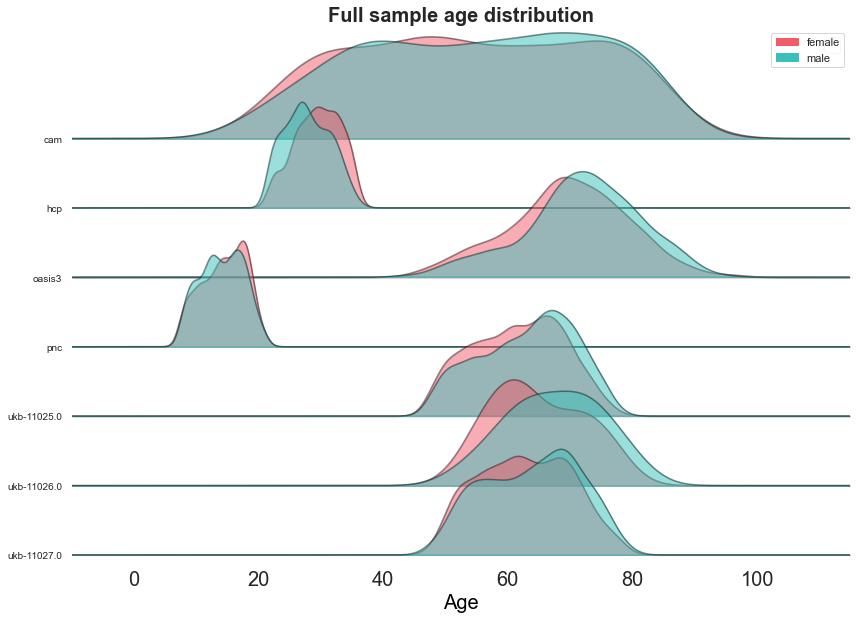

In [61]:
if plot:
    df = pd.concat([df_tr, df_te])
    dfs = [rows for _, rows in df.groupby('sex')]
    dfs[0].rename(columns={'age': 'female'}, inplace=True)
    dfs[1].rename(columns={'age': 'male'}, inplace=True)
    df2 = pd.concat([dfs[0], dfs[1]])
    site_counts = df2['site'].value_counts()  
    plt.figure(figsize=(40,10), dpi=300)
    fig, axes = joypy.joyplot(df2, column=['female', 'male'], by="site", ylim='own', figsize=(12, 8), legend=True,
                              color=['#f35b6a', '#39c0ba'], alpha=0.5)
    plt.title('Full sample age distribution', fontweight='bold', fontsize=20)
    plt.xlabel('Age', color='black', fontsize=20)
    plt.ylabel('Site ({} subjects)'.format(len(df2)), color='black', fontsize=20)
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)  
    plt.legend(fontsize=20)

In [11]:
Z_df.set_index(df_te['sub_id'], inplace=True)

Match the indexes from the CNVs to the imaging indexes, as UKB changes the indexes per dataset.

In [12]:
EXPV = pd.read_pickle(proc_dir + '/vox_powell_01/EXPV_estimate.pkl') 
MSLL = pd.read_pickle(proc_dir + '/vox_powell_01/MSLL_estimate.pkl') 
BIC = pd.read_pickle(proc_dir + '/vox_powell_01/BIC_estimate.pkl') 
NLL = pd.read_pickle(proc_dir + '/vox_powell_01/NLL_estimate.pkl') 
skew = pd.DataFrame(Z_df.skew(axis=0))
kurtosis = pd.DataFrame(Z_df.kurtosis(axis=0))
print(f'Max explained variance: {EXPV.max()}')

Max explained variance: 0    0.523905
dtype: float64


In [13]:
index1 = skew>-5
index2 = kurtosis<10
index = np.logical_and(index1,index2)
print(f'Total number of voxels:{np.sum(index)}')
print(f'Number of voxels removed: {np.sum(~index)}')

Total number of voxels:0    227083
dtype: int64
Number of voxels removed: 0    1370
dtype: int64


## Filter CNV file
We filter the CNVs based on criteria esablished in the paper: 'Cognitive Performance Among Carriers of Pathogenic Copy Number Variants: Analysis of 152,000 UK Biobank Subjects'.

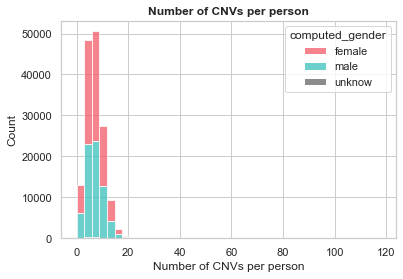

In [14]:
UKB_genetics['NumCNV_in_this_person'] = pd.to_numeric(UKB_genetics['NumCNV_in_this_person'], errors='coerce')
if plot:
    sns.histplot(data=UKB_genetics[UKB_genetics["NumCNV_in_this_person"]<120], x="NumCNV_in_this_person", bins = 40, multiple="stack", kde=False, palette = ['#f35b6a', '#39c0ba', '#666666'], hue = 'computed_gender') 
    plt.title('Number of CNVs per person', fontweight = "bold")
    plt.xlabel('Number of CNVs per person')

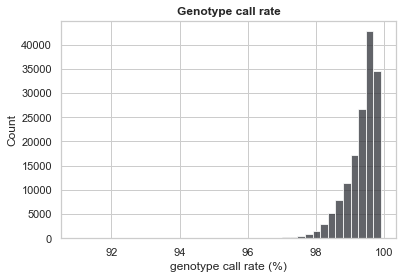

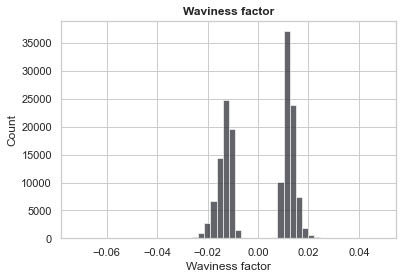

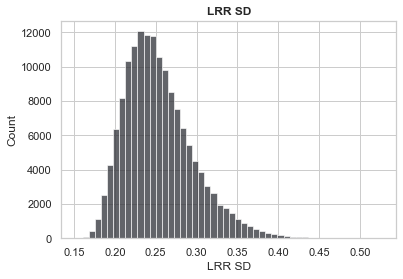

In [15]:
UKB_genetics = UKB_genetics.dropna()
UKB_genetics['call_rate'] = UKB_genetics['call_rate'].astype(float)
UKB_genetics['WavinessFactor'] = UKB_genetics['WavinessFactor'].astype(float)
UKB_genetics['LRR_SD'] = UKB_genetics['LRR_SD'].astype('float')
if plot:
    plt.figure()
    sns.histplot(data=UKB_genetics, x="call_rate", bins = 40, multiple="stack", kde=False)
    plt.xlabel('genotype call rate (%)')
    plt.title('Genotype call rate', fontweight='bold')
    
    plt.figure()
    sns.histplot(data=UKB_genetics, x="WavinessFactor", bins = 50, multiple="stack", kde=False)
    plt.xlabel('Waviness factor')
    plt.title('Waviness factor', fontweight='bold')
    
    plt.figure()
    sns.histplot(data=UKB_genetics, x="LRR_SD", bins = 50, multiple="stack", kde=False)
    plt.xlabel('LRR SD')
    plt.title('LRR SD', fontweight='bold')
 

In [16]:
# Define the filtering criteria
cnv_threshold = 30
call_rate_threshold = 0.96
waviness_factor_threshold = 0.03

UKB_genetics_filtered = UKB_genetics[(UKB_genetics['NumCNV_in_this_person'] <= cnv_threshold) &
(UKB_genetics['call_rate'] >= call_rate_threshold) &
(UKB_genetics['WavinessFactor'].between(-waviness_factor_threshold, waviness_factor_threshold))]

No subjects were removed in the UKB_cnv file using the filtering method for the entire genetics sample

## Change index
Within the UKB you will get multiple keys per dataset so we have to match these.

In [17]:
key2 = pd.read_csv('/project_freenas/3022017.02/UKB/docs/ukb23668bridge14421.txt', sep=' ', header=None, index_col = 1)
key2
UKB_cnv['sub_index2']= key2.loc[list(UKB_cnv.index)]
UKB_cnv = UKB_cnv.set_index('sub_index2')
print(f"Number of CNVs present in UKB: {len(UKB_cnv['Pathogenic_CNV'].unique())}")

Number of CNVs present in UKB: 70


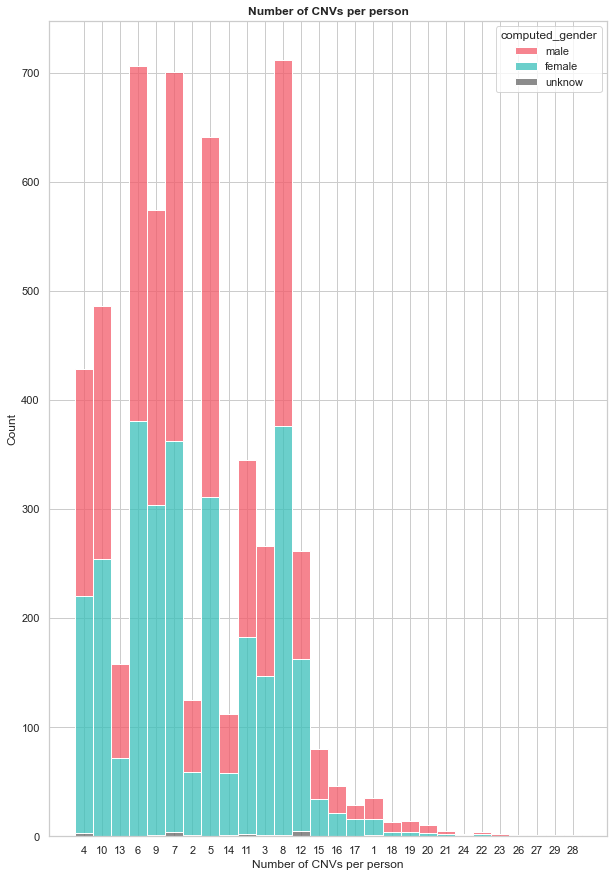

In [19]:
if plot:
    plt.figure(figsize=(10,15))
    sns.histplot(data=concatenated_CNV_data, x="NumCNV_in_this_person", bins = 20, multiple="stack", kde=False, palette = ['#f35b6a', '#39c0ba', '#666666'], hue = 'computed_gender') 
    plt.title('Number of CNVs per person', fontweight = "bold")
    plt.xlabel('Number of CNVs per person')

In [ ]:
if plot:
    plt.figure(figsize=(10,25))
    concatenated_CNV_data['Pathogenic_CNV'].value_counts().plot(kind='barh', color=colors[2])
    plt.title('Number participants with specific CNV', fontweight = "bold")
    plt.xlabel('Number participants with specific CNV')

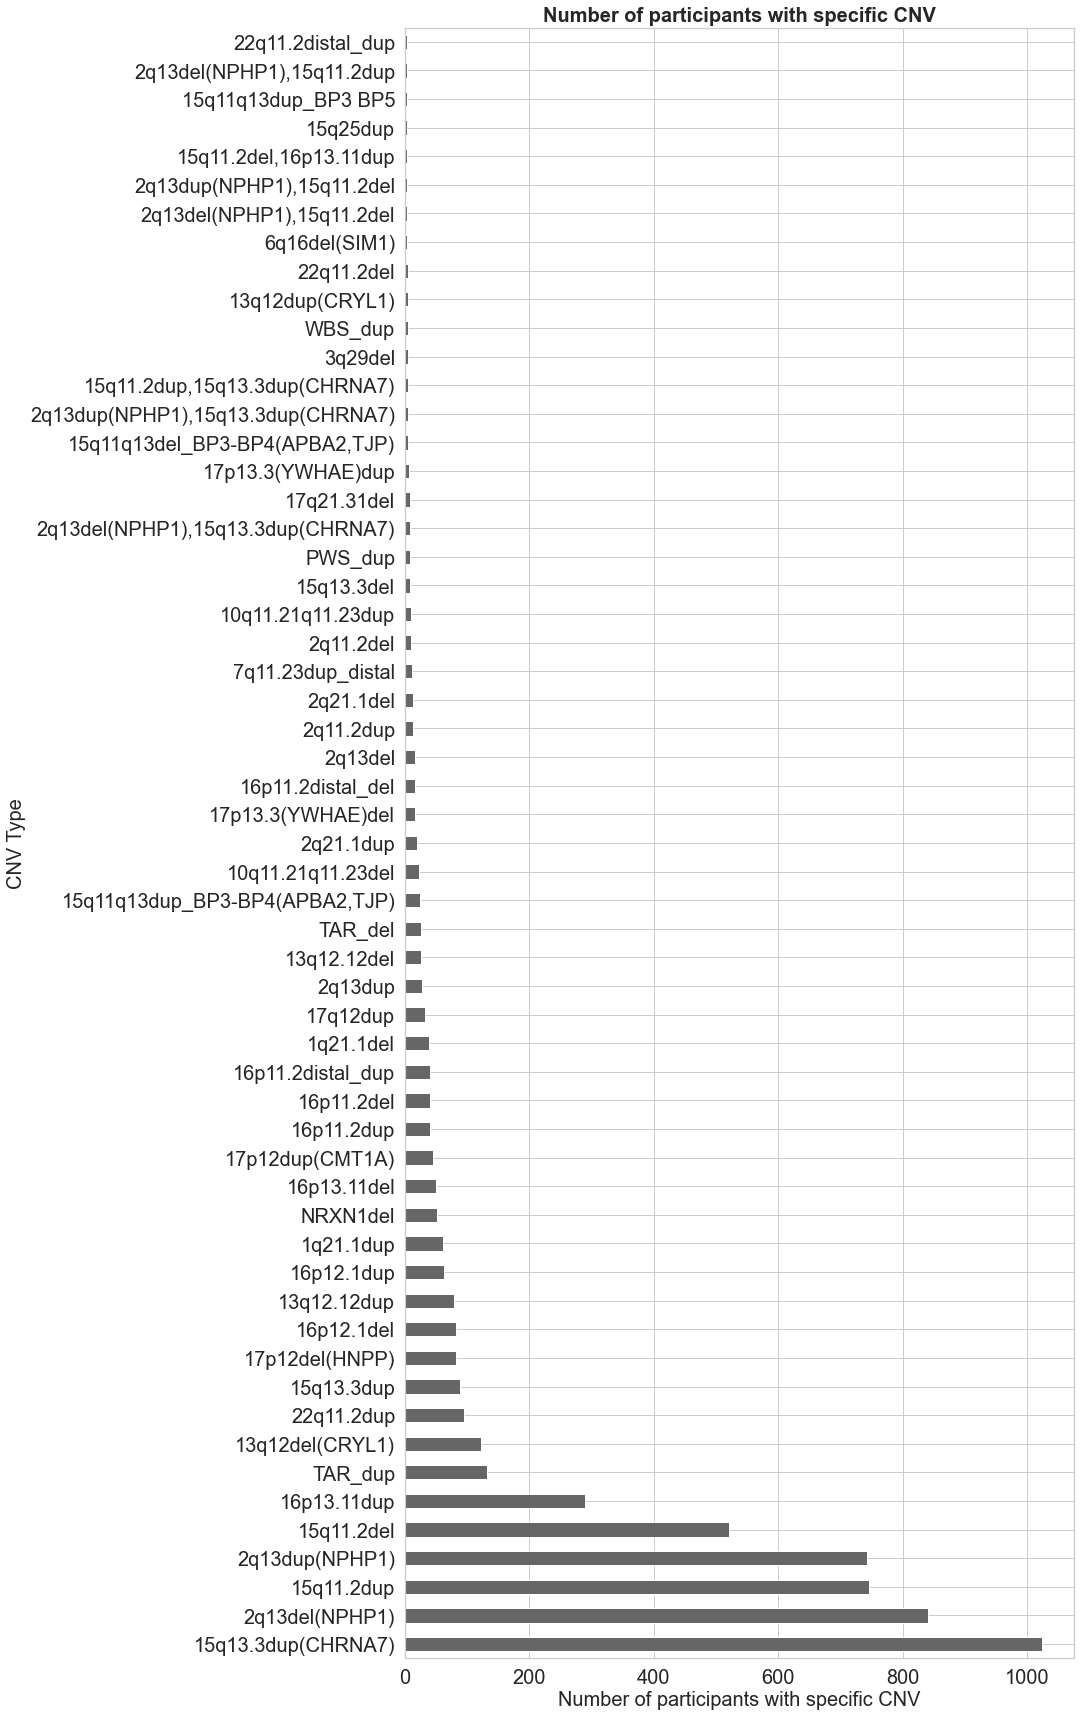

In [20]:
if plot:
    plt.figure(figsize=(12, 30))
    value_counts = concatenated_CNV_data['Pathogenic_CNV'].value_counts()
    # Filter the value counts to keep only those with more than 1 count
    value_counts_filtered = value_counts[value_counts > 2]
    value_counts_filtered.plot(kind='barh', color=colors[2])
    plt.title('Number of participants with specific CNV', fontsize=20, fontweight="bold")
    plt.xlabel('Number of participants with specific CNV', fontsize=20)
    plt.ylabel('CNV Type', fontsize=20)  
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=20) 
    plt.show()

### Pick CNV

In [21]:
Pathogenic_CNV = list(UKB_cnv['Pathogenic_CNV'].unique())

Check specific participants with a lot of outliers

In [23]:
deviation_counts = pd.DataFrame(index = Z_df.index)
deviation_counts['positive_count'] = Z_df[Z_df>=2].count(axis=1)
deviation_counts['negative_count'] = Z_df[Z_df<-2].count(axis=1)

In [24]:
idx = np.intersect1d(deviation_counts.index, UKB_cnv.index.astype(str))
devation_cnv = deviation_counts.loc[idx]

In [25]:
print(f'Number subjects with both voxel and CNV data: {len(devation_cnv)}')

Number subjects with both voxel and CNV data: 375


# Demographics CNV participants

In [26]:
df_all = pd.concat([df_tr,df_te])
df_all = pd.concat([df_tr,df_te])
df_all.set_index('sub_id', inplace=True)

In [27]:
UKB_cnv.index = UKB_cnv.index.astype(str)

In [28]:
df = UKB_cnv['Pathogenic_CNV'][idx]
df_combined = df.groupby(df.index).apply(lambda x: ','.join(x))
df_combined
devation_cnv['Pathogenic_CNV'] = df_combined

In [29]:
deviation_counts['CNV'] = 0
deviation_counts['CNV'][idx] = UKB_cnv.loc[idx][~UKB_cnv.loc[idx].index.duplicated()]['Pathogenic_CNV']
devation_cnv['Pathogenic_CNV'].unique()

array(['15q13.3dup(CHRNA7)', 'TAR_dup', '15q11.2del', '2q13del(NPHP1)',
       '15q11.2del,16p13.11dup', '13q12del(CRYL1)', '2q13dup',
       '13q12.12del', '13q12.12dup', '16p12.1dup', '16p13.11dup',
       '17p12del(HNPP)', '2q13dup(NPHP1)',
       '15q11q13del_BP3-BP4(APBA2,TJP)', '17p13.3(YWHAE)del',
       '16p12.1del', '2q13dup(NPHP1),15q13.3dup(CHRNA7)', '15q11.2dup',
       '15q13.3dup', '17p12dup(CMT1A)', '15q11.2dup,15q13.3dup(CHRNA7)',
       '16p11.2del', '1q21.1del', '2q11.2del', '7q11.23dup_distal',
       'WBS_dup', '16p11.2dup', '16p13.11del',
       '15q11q13dup_BP3-BP4(APBA2,TJP)', 'NRXN1del', '1q21.1dup',
       '8p23.1dup', '22q11.2dup', '2q11.2dup',
       '2q13del(NPHP1),13q12.12dup', '15q11.2del,16p12.1dup', '3q29del'],
      dtype=object)

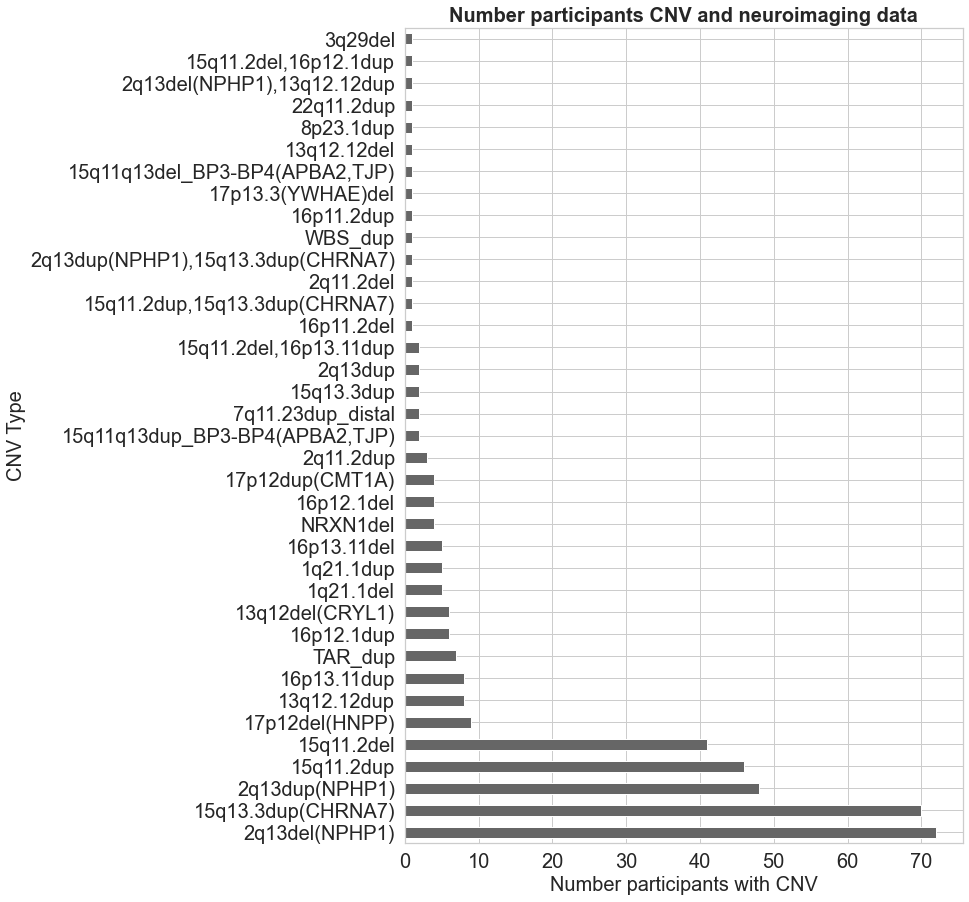

In [30]:
if plot:
    plt.figure(figsize=(10, 15))
    devation_cnv['Pathogenic_CNV'].value_counts().plot(kind='barh', color=colors[2])
    plt.title('Number participants CNV and neuroimaging data', fontsize=20, fontweight="bold")
    plt.xlabel('Number participants with CNV', fontsize=20)
    plt.ylabel('CNV Type', fontsize=20)
    plt.xticks(fontsize=20) 
    plt.yticks(fontsize=20) 
    plt.show()

## Effect size CNV on cognition

In [31]:
devation_cnv[devation_cnv['Pathogenic_CNV']==cnv_to_model]
len(devation_cnv[devation_cnv['negative_count']>50])
with open('/home/preclineu/chafra/Desktop/data/index_csv_neg_50.txt', 'w') as file:
    file.write('\n'.join(str(index) for index in devation_cnv[devation_cnv['negative_count']>50].index))
devation_cnv_l = list(devation_cnv['Pathogenic_CNV'])

## Create brain figures

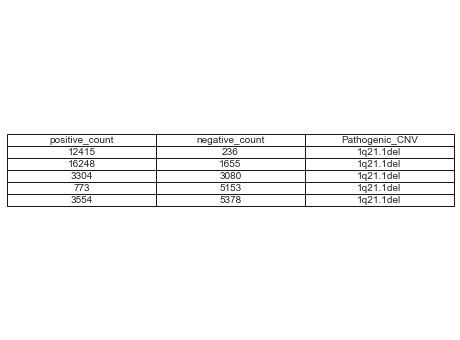

In [32]:
df_csv = devation_cnv[devation_cnv['Pathogenic_CNV'] == cnv_to_model].sort_values('negative_count')
if plot:
    plt.figure(figsize=(8, 6))
    plt.axis('off')  
    plt.table(cellText=df_csv.values, colLabels=df_csv.columns, cellLoc='center', loc='center')

In [33]:
root_dir = '/project_cephfs/3022017.06/projects/wholebrain_blr/lifespan/'
data_dir = os.path.join(root_dir,'data/')
ex_nii = os.path.join(data_dir, 'camcan_aff+nonlin_jac.nii.gz')
mask_nii = '/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz'
proc_dir = os.path.join(root_dir,'aff+nonlin_jac_char')

nr = len(df_csv)
all_z_subs = []  

for index in df_csv.index: 
   Z_one_sub = Z_df.loc[index].values
   Z_one_sub = Z_one_sub.reshape((len(Z_one_sub),1))
   all_z_subs.append(Z_one_sub)
   ptksave(Z_one_sub.T, os.path.join(save_path, cnv_to_model+'_Z_CNV_' + index + '_' + str(nr) + '.nii.gz'), example=ex_nii, mask=mask_nii)
   nr -= 1

mean_z_sub = np.mean(np.hstack(all_z_subs), axis=1).reshape((-1, 1))
ptksave(mean_z_sub.T, os.path.join(save_path, cnv_to_model+'_Z_CNV_mean.nii.gz'), example=ex_nii, mask=mask_nii)

In [34]:
negative_total_count = np.sum(np.array(all_z_subs) < -2, axis=0)
percentage_score = (negative_total_count / np.shape(all_z_subs)[0]) * 100
np.shape(percentage_score)
ptksave(percentage_score.T, os.path.join(save_path, cnv_to_model+'_Z_CNV_extremes.nii.gz'), example=ex_nii, mask=mask_nii)

In [35]:
positive_total_count = np.sum(np.array(all_z_subs) > 2, axis=0)
percentage_score = (positive_total_count / np.shape(all_z_subs)[0]) * 100
np.shape(percentage_score)
ptksave(percentage_score.T, os.path.join(save_path, cnv_to_model+'_Z_CNV_extremes_pos.nii.gz'), example=ex_nii, mask=mask_nii)

## Plot violin and box plot deviations

In [36]:
deviation_counts['CNV_present'] = np.where(deviation_counts['CNV'] != 0, 1, deviation_counts['CNV'])

In [37]:
deviation_counts.loc[deviation_counts["CNV"] == 0, "CNV"] = 'No-CNV'

In [38]:
deviation_counts['CNV_present'] = np.where(deviation_counts['CNV'] != 0, 1, deviation_counts['CNV'])

In [39]:
deviation_counts['CNV_to_model'] = 0
deviation_counts.loc[deviation_counts['CNV'] == cnv_to_model, 'CNV_to_model'] = cnv_to_model

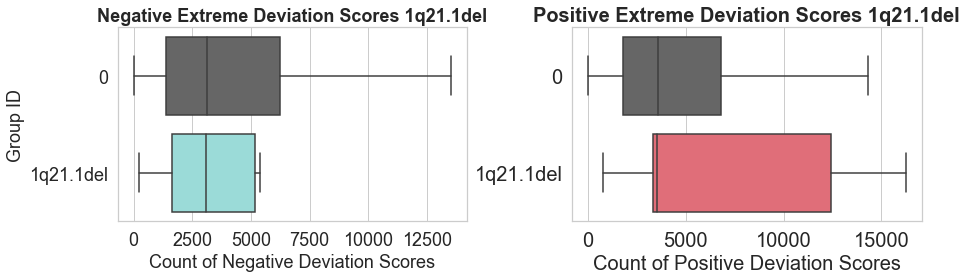

In [40]:
cnv_data = deviation_counts[(deviation_counts["CNV"] == cnv_to_model) | (deviation_counts["CNV"] == 'No-CNV')]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

sns.boxplot(data=deviation_counts, x="negative_count", y="CNV_to_model", showfliers=False, ax=ax1, palette=['#666666', '#90e6e2'])
ax1.set_title('Negative Extreme Deviation Scores ' + cnv_to_model, fontweight='bold', fontsize=18)
ax1.set_xlabel('Count of Negative Deviation Scores', fontsize=18)
ax1.set_ylabel('Group ID', fontsize=18)  
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)

sns.boxplot(data=deviation_counts, x="positive_count", y="CNV_to_model", showfliers=False, ax=ax2, palette=['#666666', '#f35b6a', '#fbb2b9', '#999fa9'])
ax2.set_title('Positive Extreme Deviation Scores ' + cnv_to_model, fontweight='bold', fontsize=20)
ax2.set_xlabel('Count of Positive Deviation Scores', fontsize=20)
ax2.set_ylabel('')  
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  

In [41]:
HC_pos = deviation_counts[deviation_counts['CNV_present'] == 0].positive_count.values
D_pos = deviation_counts[deviation_counts['CNV_present'] == 1].positive_count.values
HC_neg = deviation_counts[deviation_counts['CNV_present'] == 0].negative_count.values
D_neg = deviation_counts[deviation_counts['CNV_present'] == 1].negative_count.values

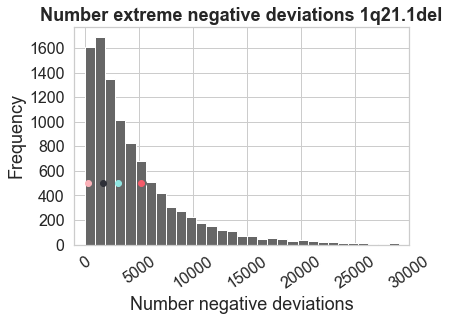

In [42]:
devation_cnv_l = [cnv_to_model]
for cnv in devation_cnv_l:
    probability_density = []
    p = []
    plt.figure()
    plt.hist(deviation_counts['negative_count'], bins=200, color = '#666666')
    j = 0
    for i in devation_cnv[devation_cnv['Pathogenic_CNV']==cnv].negative_count.values:
        plt.plot([i], 500, 'o') # Your original list
        j += 1
    plt.xlabel('Number negative deviations', fontsize=18)
    plt.xlim([-1000,30000])
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(rotation = 35, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Number extreme negative deviations ' + cnv, fontweight="bold", fontsize=18)
    plt.show()

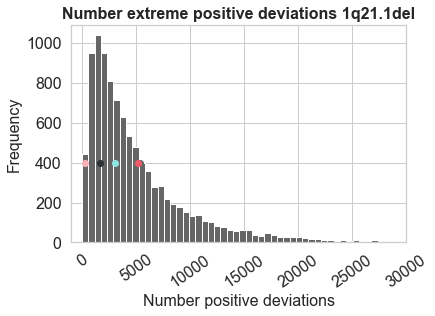

In [43]:
devation_cnv_l = [cnv_to_model]
for cnv in devation_cnv_l:
    probability_density = []
    p = []
    plt.figure()
    plt.hist(deviation_counts['positive_count'], bins=100, color = '#666666')
    j = 0
    for i in devation_cnv[devation_cnv['Pathogenic_CNV']==cnv].negative_count.values:
        plt.plot([i], 400, 'o') # Your original list
        j += 1
    plt.xlabel('Number positive deviations', fontsize=16)
    plt.xlim([-1000,30000])
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(rotation = 35, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Number extreme positive deviations ' + cnv, fontweight="bold", fontsize=16)
    plt.show()

# Box plots deviation scores

In [44]:
deviation_counts['all_counts'] = deviation_counts['positive_count'] + deviation_counts['negative_count']
HC_pos = deviation_counts[deviation_counts['CNV'] == 0].positive_count.values
CNV_pos = deviation_counts[deviation_counts['CNV'] == 1].positive_count.values
HC_neg = deviation_counts[deviation_counts['CNV'] == 0].negative_count.values
CNV_neg = deviation_counts[deviation_counts['CNV'] == 1].negative_count.values

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'No-CNV'),
  Text(1, 0, 'NRXN1del'),
  Text(2, 0, '15q13.3dup(CHRNA7)'),
  Text(3, 0, '2q13dup'),
  Text(4, 0, '15q11.2del'),
  Text(5, 0, '2q13del(NPHP1)'),
  Text(6, 0, '17p12dup(CMT1A)'),
  Text(7, 0, '13q12del(CRYL1)'),
  Text(8, 0, 'TAR_dup'),
  Text(9, 0, '13q12.12del'),
  Text(10, 0, '13q12.12dup'),
  Text(11, 0, '16p12.1dup'),
  Text(12, 0, '16p13.11dup'),
  Text(13, 0, '17p12del(HNPP)'),
  Text(14, 0, '2q13dup(NPHP1)'),
  Text(15, 0, '15q11q13del_BP3-BP4(APBA2,TJP)'),
  Text(16, 0, '17p13.3(YWHAE)del'),
  Text(17, 0, '16p12.1del'),
  Text(18, 0, '15q11.2dup'),
  Text(19, 0, '15q13.3dup'),
  Text(20, 0, '16p11.2del'),
  Text(21, 0, '1q21.1del'),
  Text(22, 0, '2q11.2del'),
  Text(23, 0, '7q11.23dup_distal'),
  Text(24, 0, 'WBS_dup'),
  Text(25, 0, '16p11.2dup'),
  Text(26, 0, '16p13.11del'),
  Text(27, 0, '15q11q13dup

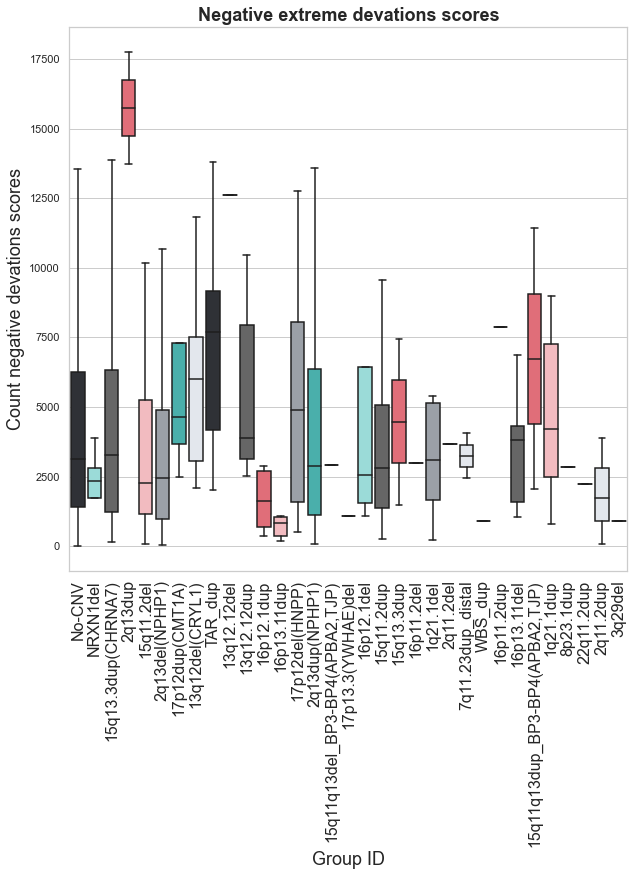

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=deviation_counts, y="negative_count", x="CNV", showfliers=False, palette = colors)
plt.title('Negative extreme devations scores', fontweight='bold', fontsize=18)
plt.ylabel('Count negative devations scores', fontsize=18)
plt.xlabel('Group ID', fontsize=18)
plt.xticks(rotation=90, fontsize=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'No-CNV'),
  Text(1, 0, 'NRXN1del'),
  Text(2, 0, '15q13.3dup(CHRNA7)'),
  Text(3, 0, '2q13dup'),
  Text(4, 0, '15q11.2del'),
  Text(5, 0, '2q13del(NPHP1)'),
  Text(6, 0, '17p12dup(CMT1A)'),
  Text(7, 0, '13q12del(CRYL1)'),
  Text(8, 0, 'TAR_dup'),
  Text(9, 0, '13q12.12del'),
  Text(10, 0, '13q12.12dup'),
  Text(11, 0, '16p12.1dup'),
  Text(12, 0, '16p13.11dup'),
  Text(13, 0, '17p12del(HNPP)'),
  Text(14, 0, '2q13dup(NPHP1)'),
  Text(15, 0, '15q11q13del_BP3-BP4(APBA2,TJP)'),
  Text(16, 0, '17p13.3(YWHAE)del'),
  Text(17, 0, '16p12.1del'),
  Text(18, 0, '15q11.2dup'),
  Text(19, 0, '15q13.3dup'),
  Text(20, 0, '16p11.2del'),
  Text(21, 0, '1q21.1del'),
  Text(22, 0, '2q11.2del'),
  Text(23, 0, '7q11.23dup_distal'),
  Text(24, 0, 'WBS_dup'),
  Text(25, 0, '16p11.2dup'),
  Text(26, 0, '16p13.11del'),
  Text(27, 0, '15q11q13dup

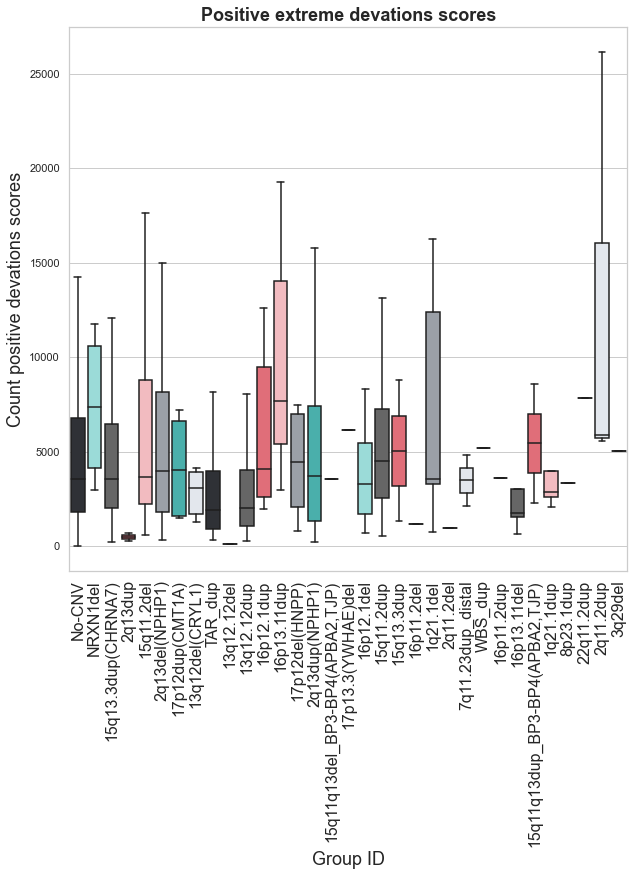

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=deviation_counts, y="positive_count", showfliers=False, x="CNV", palette = colors)
plt.title('Positive extreme devations scores', fontweight='bold', fontsize=18)
plt.ylabel('Count positive devations scores', fontsize=18)
plt.xlabel('Group ID', fontsize=18)
plt.xticks(rotation=90, fontsize=16)

# Correlation to behaviour

In [47]:
def retrieve_UKBB_covariates(csv_file_path, fields_code_list, fileds_name_list, 
                             save_path = None, drop_nans = True):
    '''
    Example:
        csv_file_path = '/project_freenas/3022017.02/UKB/phenotypes/ukb35187.csv'
        save_path =  '/project_freenas/3022017.02/UKB/phenotypes/test.csv'
        fields_code_list = ['21003-2.0', '31-0.0', '54-2.0']
        fileds_name_list = ['age', 'gender', 'site_id']
        
        covariates, subs = retrieve_UKBB_covariates(csv_file_path, fields_code_list, 
                                          fileds_name_list, save_path)
    '''
    
    ukbb_covariates = pd.read_csv(csv_file_path, encoding= 'unicode_escape', 
                                   usecols=['eid'] + fields_code_list)
    if drop_nans:
        ukbb_covariates = ukbb_covariates.dropna()
    ukbb_subs = list(ukbb_covariates['eid'])
    ukbb_subs = [str(u) for u in ukbb_subs]
    ukbb_covariates['eid'] = ukbb_subs
    ukbb_covariates = ukbb_covariates.set_index('eid')
    c = dict()
    for i, code in enumerate(fields_code_list):
        c[code] = fileds_name_list[i]
    ukbb_covariates = ukbb_covariates.rename(columns=c)
    if save_path is not None:
        ukbb_covariates.to_csv(save_path)
    return ukbb_covariates, ukbb_subs

In [48]:
# Remove num memory, for very few participants and pros mem, as categorical
# https://biobank.ctsu.ox.ac.uk/crystal/label.cgi?id=100026
cp_code_list = ['4282-2.0', # Numeric memory
                '20016-2.0', # Reasoning/fluid int
                '20023-2.0', # Reaction time
                '399-2.2', # Visual memory, pair matching
                '21004-2.0', # tower_rearranging, number puzzles correct
                #'6348-2.0', # duration trail n
                #'6350-2.0', # duration trail a
                '6373-2.0', # matrix pattern puzzles solved
                '23324-2.0' # digits matched correctly
               ] #  399 had 3 pair and 6 pair
cp_name_list = ['numeric memory',
                'fluid intelligence', 
                'reaction time', 
                'visual memory', 
                'tower rearranging', 
                #'trail making n', 
                #'trail making a',
                'matrix pattern completion', 
                'symbol digit substitution'
               ] #'numeric_memory'
CPs, subs = retrieve_UKBB_covariates('/project_freenas/3022017.02/UKB/phenotypes/current/32_cognitive_phenotypes.csv', cp_code_list, cp_name_list)
CPs.index = CPs.index.astype(int)

The trail making test contains a lot of zeros and is very non-normal so we remove the test for now.

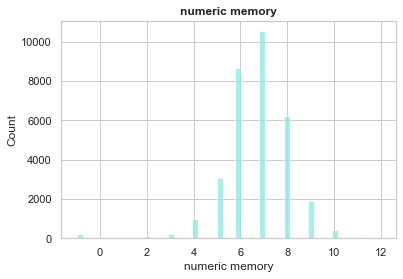

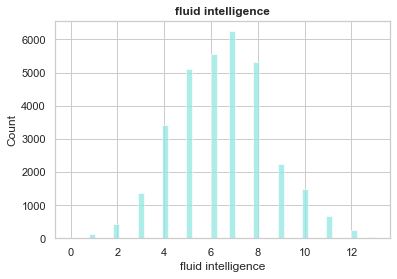

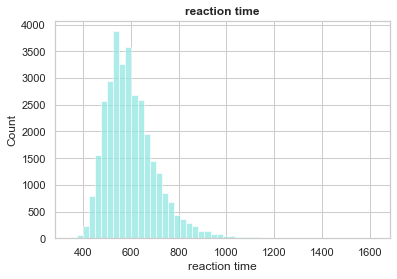

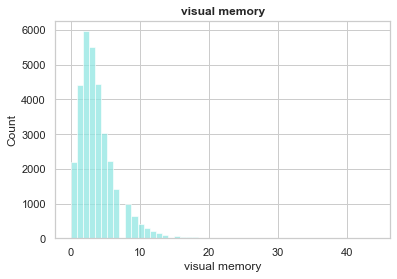

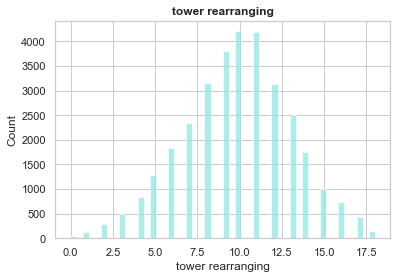

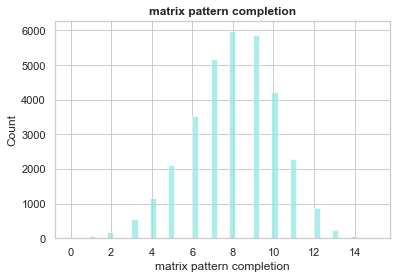

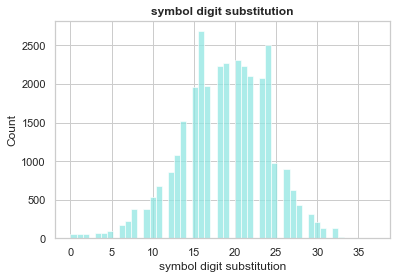

In [49]:
if plot:
    for cp in cp_name_list:
        plt.figure()
        sns.histplot(data=CPs[cp], bins = 50, color=colors[1])
        plt.title(cp, fontweight='bold')

In [50]:
CPs['visual memory'] = np.log1p(CPs['visual memory'])
CPs['reaction time'] = np.log(CPs['reaction time'])
standardize = lambda x: (x-x.mean()) / x.std() 
CPs_z = CPs.pipe(standardize)

In [51]:
CPs_z.index = CPs_z.index.astype(str)
CPs.index = CPs.index.astype(str)

common_index = deviation_counts['negative_count'].index.intersection(CPs_z.index)
negative_counts_aligned = deviation_counts['negative_count'].reindex(common_index)
CPs_z_aligned = CPs_z.reindex(common_index)
pca = PCA(n_components=CPs_z_aligned.shape[1])

pca.fit(CPs_z_aligned)
transformed_data = pca.transform(CPs_z_aligned)
first_component_values = transformed_data[:, 0]
correlation, p_value = spearmanr(negative_counts_aligned, first_component_values)

print(f"Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Correlation: -0.0369
P-value: 0.0416


In [52]:
positive_counts_aligned = deviation_counts['positive_count'].reindex(common_index)
correlation, p_value = spearmanr(positive_counts_aligned, first_component_values)
print(f"Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Correlation: 0.0304
P-value: 0.0932


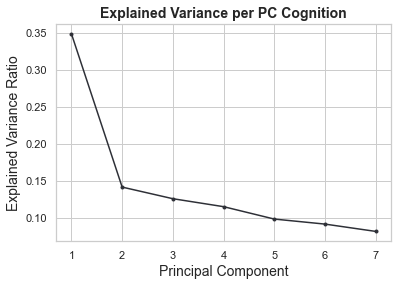

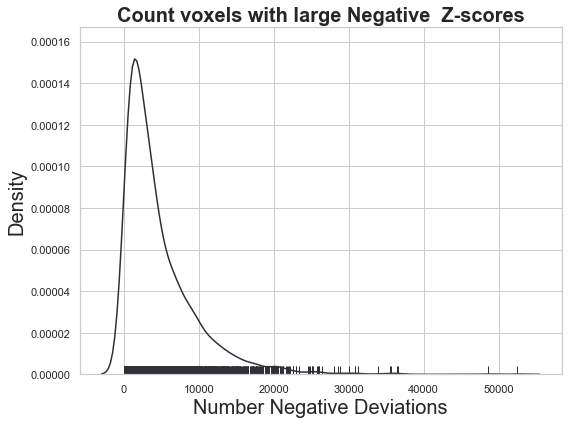

In [53]:
explained_variance_ratio = pca.explained_variance_ratio_

if plot:
    plt.figure()
    plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='.', color=colors[0])
    plt.xlabel('Principal Component', fontsize=14)
    plt.ylabel('Explained Variance Ratio', fontsize=14)
    plt.title('Explained Variance per PC Cognition', fontweight='bold', fontsize=14)
    plt.savefig(f'/home/preclineu/chafra/Desktop/figures/UKB/PCA_cog.png', dpi=300, bbox_inches = 'tight')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sns.distplot(negative_counts_aligned, hist=False, rug=True, color=colors[0])
    plt.title('Count voxels with large Negative  Z-scores', fontweight='bold', fontsize=20)  
    plt.xlabel('Number Negative Deviations', fontsize=20)  
    plt.ylabel('Density', fontsize=20) 

    plt.tight_layout()  
    plt.savefig(save_path + 'density_plot_z_scores.png', dpi=300, bbox_inches='tight')
    plt.show()

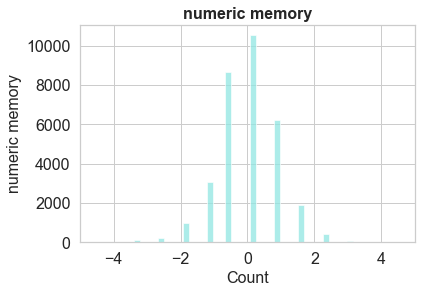

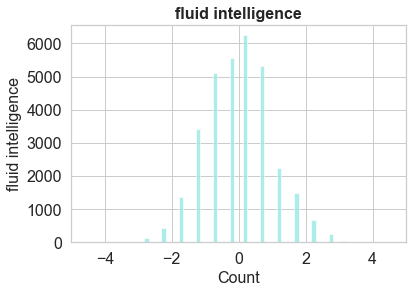

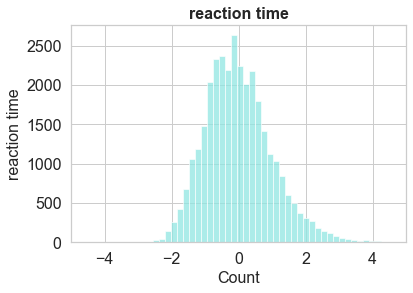

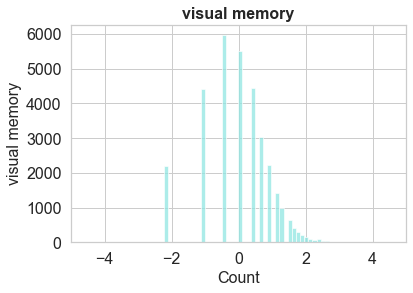

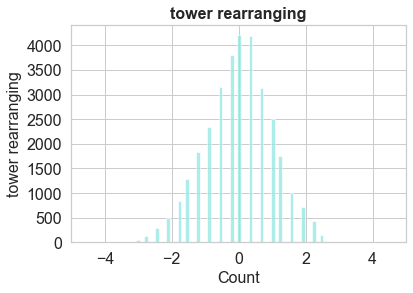

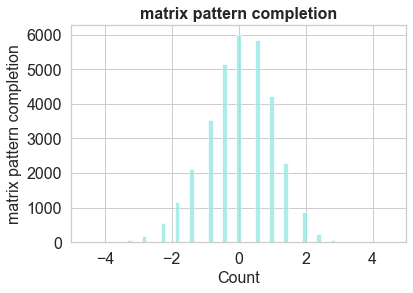

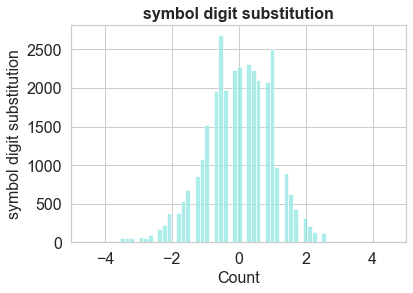

In [54]:
if plot:
    for cp in cp_name_list:
        plt.figure()
        sns.histplot(data=CPs_z[cp], bins=50, color=colors[1])
        plt.title(cp, fontweight='bold', fontsize=16)
        plt.xlabel('Count', fontsize=16)  
        plt.ylabel(cp, fontsize=16)  
        skewness = round(CPs_z[cp].skew(), 3)
        kurtosis = round(CPs_z[cp].kurtosis(), 3)
        max_count = np.round(CPs_z[cp], 1).value_counts().max()
        plt.xlim(-5, 5)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.savefig('/home/preclineu/chafra/Desktop/figures/' + cp + '.png', dpi=300, bbox_inches='tight')


In [55]:
UKB_cnv_schiz = UKB_cnv[UKB_cnv['Pathogenic_CNV'].isin(['15q11.2del', '15q13.3del','16p11.2dup', '16p12.1del', '1q21.1del', '1q21.1dup', '22q11.2del', '3q29del', 'NRXN1del', 'PWS_dup', 'WBS_dup'])]
UKB_cnv_dev = UKB_cnv[UKB_cnv['Pathogenic_CNV'].isin(['15q11.2dup', '15q24dup', '16p11.2del', '16p11.2distal_del', '16p11.2distal_dup', '16p13.11del', '17p13.3(PAFAH1B1)del', '17p13.3(YWHAE)del', '17p13.3(PAFAH1B1)dup', '17p13.3(YWHAE)dup', '17q11.2del(NF1)', '17q11.2dup(NF1)', '17q12dup','17q21.31del', '22q11.2distal_del', '22q11.2distal_dup', '22q11.2dup',  '2q11.2del', '2q13del', '2q13dup', '8p23.1dup',  'Potocki-Lupski', '17q12del', 'TAR_del', 'TAR_dup',  'WBS_del', 'W-Hdup'])]

In [56]:
idx = np.intersect1d(CPs_z.index, UKB_cnv.index)
idx_schiz = np.intersect1d(CPs_z.index, UKB_cnv_schiz.index)
idx_dev = np.intersect1d(CPs_z.index, UKB_cnv_dev.index)

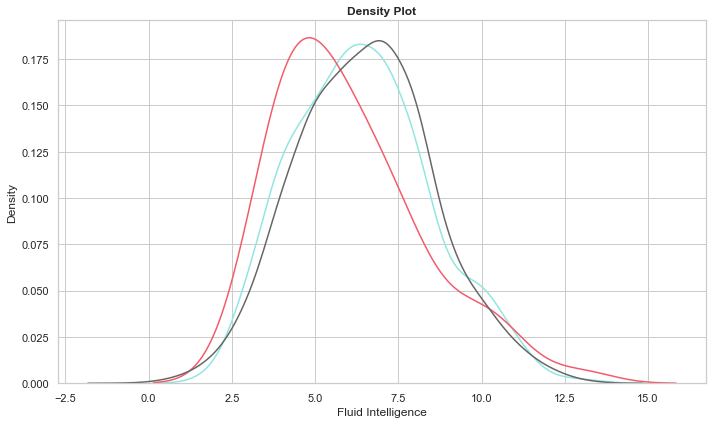

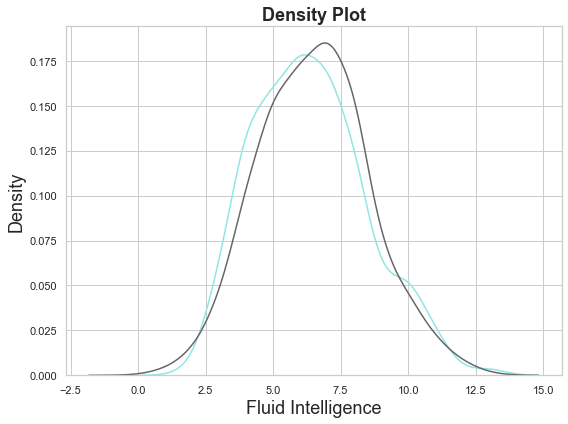

In [57]:
if plot:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=CPs['fluid intelligence'].loc[idx], color=colors[1], label='S-CNV carriers')
    sns.kdeplot(data=CPs['fluid intelligence'].loc[idx_dev], color=colors[3], label='D-CNV carriers')
    sns.kdeplot(data=CPs['fluid intelligence'][~CPs.index.isin(idx)], bw_method=0.3, color=colors[2], label='non-CNV')
    plt.title('Density Plot', fontweight='bold')
    plt.xlabel('Fluid Intelligence')
    plt.ylabel('Density')
    plt.tight_layout()  
    plt.savefig(save_path + 'density_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    combined_data = CPs['fluid intelligence'].loc[idx].append(CPs['fluid intelligence'].loc[idx_dev])
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=combined_data, color=colors[1], label='Pathogenic CNV carriers')
    sns.kdeplot(data=CPs['fluid intelligence'][~CPs.index.isin(idx) & ~CPs.index.isin(idx_dev)], bw_method=0.3, color=colors[2], label='non-CNV')
    plt.title('Density Plot', fontweight='bold', fontsize=18)  
    plt.xlabel('Fluid Intelligence', fontsize=18)  
    plt.ylabel('Density', fontsize=18)  
    plt.tight_layout()  
    plt.savefig(save_path + 'density_plot2.png', dpi=300, bbox_inches='tight')
    plt.show()

In [58]:
list_develop_cnvs = CNV_summary['UKB_name'][(CNV_summary['Coe_significant']==1.0) & (CNV_summary['Sz-CNV']!=1.0)]

# Correlation polygenetic risk scores

In [59]:
folder_path = '/home/preclineu/chafra/Desktop/data/polygenic_scores_UKB/'
items = ['CUD', 'BIP', 'ASD', 'MDD', 'ANX', 'ADHD', 'SCZ']
results = []

for item in items:
    file_path = os.path.join(folder_path, f'{item}_UKB.sscore')
    pgs_df = pd.read_csv(file_path, sep='\t', index_col='IID')
    pgs_df.index = pgs_df.index.astype(str)
    
    scaler = StandardScaler()
    pgs_df['SCORE1_AVG_standardized'] = scaler.fit_transform(pgs_df[['SCORE1_AVG']])
    
    common_index = Z_df.index.intersection(pgs_df.index)
    correlation, p_value = spearmanr(pgs_df['SCORE1_AVG_standardized'].loc[common_index], deviation_counts['negative_count'].loc[common_index])
    
    results.append({
        'Item': item,
        'Correlation': correlation,
        'P-value': p_value
    })

# Extract p-values for FDR correction
p_values = [result['P-value'] for result in results]
_, fdr_corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for result, fdr_p_value in zip(results, fdr_corrected_p_values):
    result['FDR P-value'] = fdr_p_value

results_df = pd.DataFrame(results)
print(results_df)


   Item  Correlation   P-value  FDR P-value
0   CUD     0.014107  0.267476     0.374466
1   BIP     0.018567  0.144421     0.252737
2   ASD     0.000027  0.998280     0.998280
3   MDD     0.020885  0.100628     0.234800
4   ANX     0.003768  0.767075     0.894921
5  ADHD    -0.025307  0.046645     0.163258
6   SCZ     0.025377  0.046041     0.163258


In [60]:
results = []

for item in items:
    file_path = os.path.join(folder_path, f'{item}_UKB.sscore')
    pgs_df = pd.read_csv(file_path, sep='\t', index_col='IID')
    pgs_df.index = pgs_df.index.astype(str)
    
    scaler = StandardScaler()
    pgs_df['SCORE1_AVG_standardized'] = scaler.fit_transform(pgs_df[['SCORE1_AVG']])
    
    common_index = Z_df.index.intersection(pgs_df.index)
    
    correlation, p_value = spearmanr(pgs_df['SCORE1_AVG_standardized'].loc[common_index], deviation_counts['positive_count'].loc[common_index])
    
    results.append({
        'Item': item,
        'Correlation': correlation,
        'P-value': p_value
    })

p_values = [result['P-value'] for result in results]
_, fdr_corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for result, fdr_p_value in zip(results, fdr_corrected_p_values):
    result['FDR P-value'] = fdr_p_value

results_df = pd.DataFrame(results)
print(results_df)

   Item  Correlation   P-value  FDR P-value
0   CUD    -0.018987  0.135552     0.474432
1   BIP    -0.009098  0.474536     0.672535
2   ASD     0.001671  0.895505     0.895505
3   MDD    -0.020445  0.107999     0.474432
4   ANX    -0.008978  0.480382     0.672535
5  ADHD     0.006165  0.627939     0.732595
6   SCZ    -0.014669  0.248861     0.580675
